In [6]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [2]:
#Uncomment to install ydata-synthetic lib
! pip install ydata-synthetic
!pip install --upgrade tensorflow-gpu tensorflow

  Using cached tensorflow-2.4.4-cp38-cp38-manylinux2010_x86_64.whl (394.6 MB)
Requirement already up-to-date: tensorflow-gpu in ./timegan/lib/python3.8/site-packages (2.7.0)
  Using cached tensorflow-2.7.0-cp38-cp38-manylinux2010_x86_64.whl (489.6 MB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
ERROR: ydata-synthetic 0.6.1 has requirement tensorflow==2.4.*, but you'll have tensorflow 2.7.0 which is incompatible.
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.4
    Uninstalling tensorflow-2.4.4:
      Successfully uninstalled tensorflow-2.4.4


# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [17]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [18]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0:1], 'GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

## Data Preparation

### Select time series features

In [32]:
cols = ['meter_reading','timestamp', 'air_temperature','cloud_coverage','dew_temperature',
'precip_depth_1_hr','sea_level_pressure','wind_speed']

In [42]:
df = pd.read_csv("/root/data_science_lab/ashrae_data/ashrae_merged_data.csv", usecols=cols)

In [45]:
df.head()

,Date,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
0,2016-01-01 00:00:00,0.000000,0.581829,-0.507915,0.270550,0.0,0.677349,-1.523010
1,2016-01-01 00:00:00,0.000000,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
2,2016-01-01 00:00:00,2.302585,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
3,2016-01-01 00:00:00,1.503766,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
4,2016-01-01 00:00:00,3.701771,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423


### Rename timestamp to Date --> TimeGAN prerequisit

In [43]:
df.rename(columns={'timestamp': 'Date'}, inplace=True)

In [44]:
df.head()

,Date,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
0,2016-01-01 00:00:00,0.000000,0.581829,-0.507915,0.270550,0.0,0.677349,-1.523010
1,2016-01-01 00:00:00,0.000000,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
2,2016-01-01 00:00:00,2.302585,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
3,2016-01-01 00:00:00,1.503766,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
4,2016-01-01 00:00:00,3.701771,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423


### Sample 100K examples to be considered in GAN training

In [46]:
df[:100000].to_csv("/root/data_science_lab/ashrae_data/ashrae_merged_data_sample100K_time_features_timeGAN.csv", index=False)

In [47]:
df = pd.read_csv("/root/data_science_lab/ashrae_data/ashrae_merged_data_sample100K_time_features_timeGAN.csv")

In [48]:
df.head()

,Date,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
0,2016-01-01 00:00:00,0.000000,0.581829,-0.507915,0.270550,0.0,0.677349,-1.523010
1,2016-01-01 00:00:00,0.000000,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
2,2016-01-01 00:00:00,2.302585,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
3,2016-01-01 00:00:00,1.503766,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423
4,2016-01-01 00:00:00,3.701771,-1.884152,1.363507,-1.885433,0.0,-0.862480,0.019423


In [49]:
df.shape

(100000, 8)

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [52]:
#Specific to TimeGANs
seq_len=24   
n_seq = 7
hidden_dim=24
gamma=1

noise_dim = 16
dim = 128
batch_size = 10000

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

## The data

In [53]:
ashrae_data = processed_stock(path='/root/data_science_lab/ashrae_data/ashrae_merged_data_sample100K_time_features_timeGAN.csv', seq_len=seq_len)
print(len(ashrae_data),ashrae_data[0].shape)

99976 (24, 7)


## Training the TimeGAN synthetizer

In [54]:
if path.exists('synthesizer_ASHRAE_100K_timefeat.pkl'):
    synth = TimeGAN.load('synthesizer_ASHRAE_100K_timefeat.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(ashrae_data, train_steps=500)
    synth.save('synthesizer_ASHRAE_100K_timefeat.pkl')

Joint networks training: 100%|██████████| 500/500 [6:49:57<00:00, 49.20s/it]  


### The generated synthetic ASHRAE data

In [55]:
synth_data = synth.sample(len(ashrae_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 10/10 [01:20<00:00,  8.09s/it]

(100000, 24, 7)


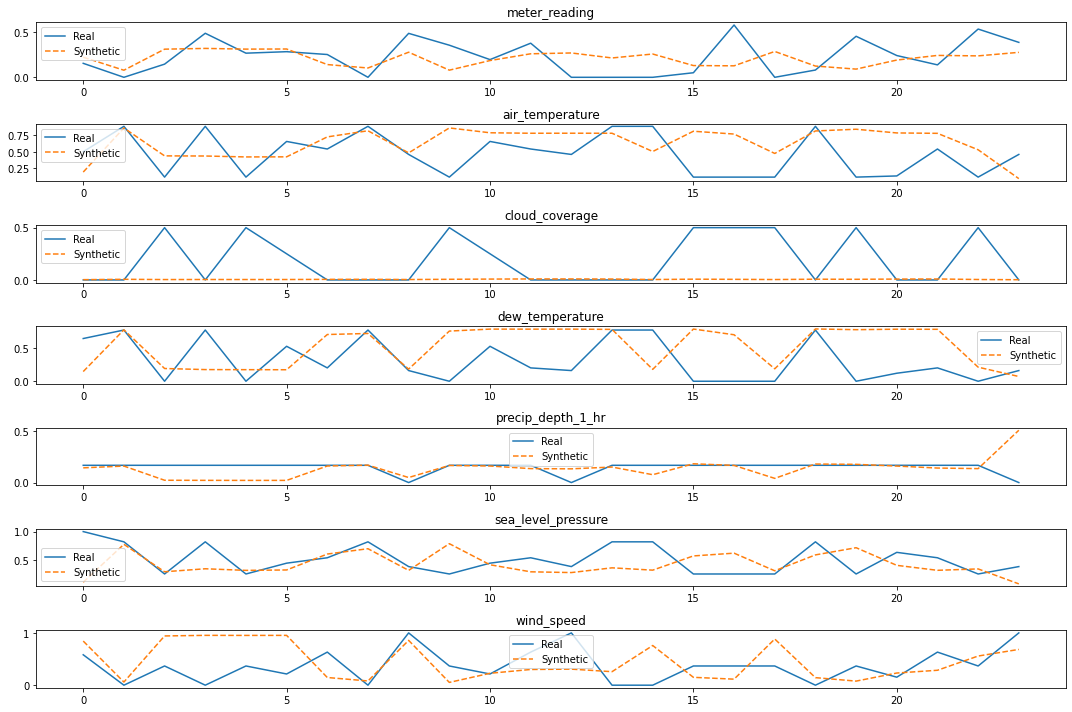

In [56]:
#Reshaping the data
cols = ['meter_reading','air_temperature',	'cloud_coverage',	'dew_temperature',	'precip_depth_1_hr',	'sea_level_pressure',	'wind_speed']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(ashrae_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': ashrae_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 500
idx = np.random.permutation(len(ashrae_data))[:sample_size]

real_sample = np.asarray(ashrae_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
ashrae_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(ashrae_data_reduced)

pca_real = pd.DataFrame(pca.transform(ashrae_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((ashrae_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/root/data_science_lab/timegan/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/data_science_lab/timegan/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

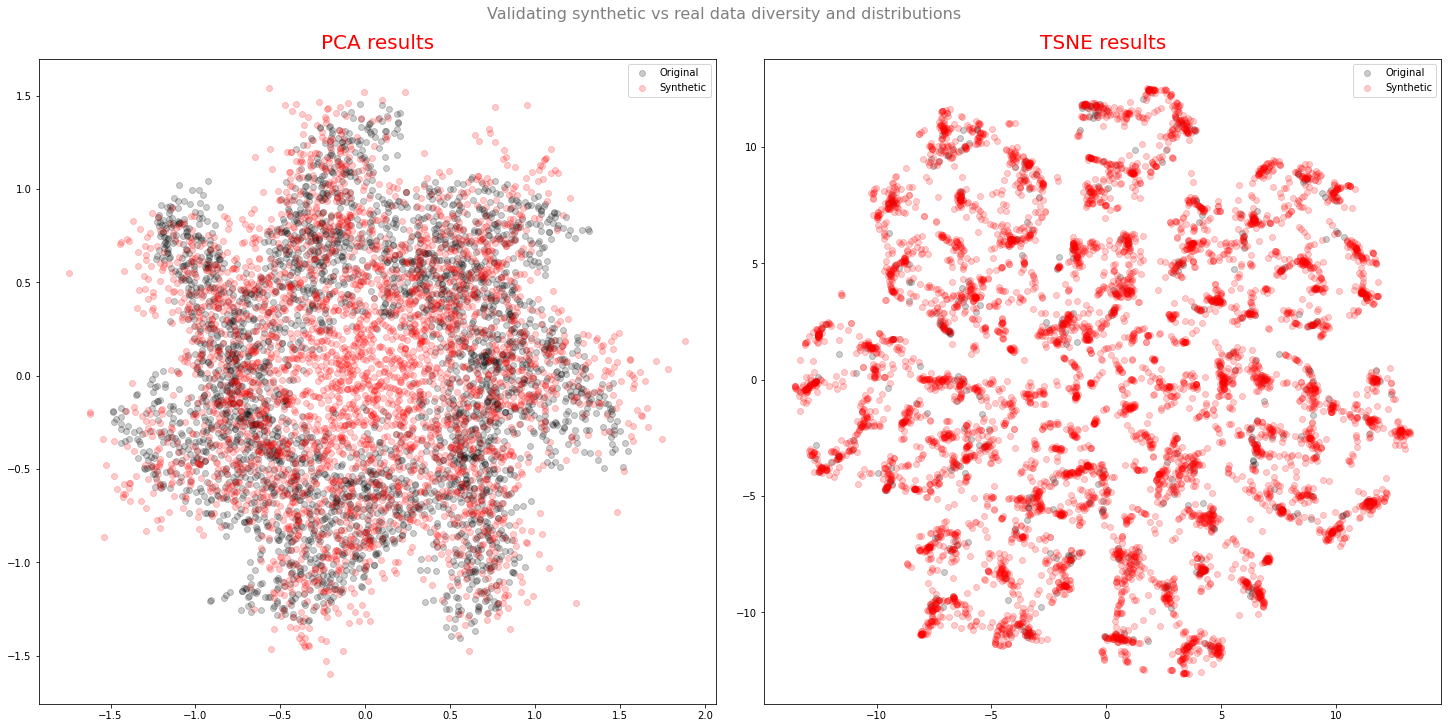

In [58]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [59]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=7,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [60]:
#Prepare the dataset for the regression model
ashrae_data=np.asarray(ashrae_data)
synth_data = synth_data[:len(ashrae_data)]
n_events = len(ashrae_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_ashrae_train = ashrae_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_ashrae_test = ashrae_data[test_idx, :seq_len-1, :]
y_ashrae_test = ashrae_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_ashrae_train = ashrae_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_ashrae_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_ashrae_train.shape))

print('Real X test: {}'.format(X_ashrae_test.shape))
print('Real y test: {}'.format(y_ashrae_test.shape))

Synthetic X train: (74982, 23, 7)
Real X train: (74982, 23, 7)
Synthetic y train: (74982, 7)
Real y train: (74982, 7)
Real X test: (24994, 23, 7)
Real y test: (24994, 7)


In [67]:
#Training the model with the real train data
ts_real = RNN_regression(24)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_ashrae_train,
                          y=y_ashrae_train,
                          validation_data=(X_ashrae_test, y_ashrae_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
586/586 [==============================] - 8s 10ms/step - loss: 0.1863 - val_loss: 0.1746
Epoch 2/200
586/586 [==============================] - 6s 10ms/step - loss: 0.1737 - val_loss: 0.1721


In [68]:
#Training the model with the synthetic data
ts_synth = RNN_regression(24)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_ashrae_test, y_ashrae_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
586/586 [==============================] - 8s 10ms/step - loss: 0.1599 - val_loss: 0.1830
Epoch 2/200
586/586 [==============================] - 5s 9ms/step - loss: 0.1441 - val_loss: 0.1858


In [69]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_ashrae_test)
synth_predictions = ts_synth.predict(X_ashrae_test)

metrics_dict = {'r2': [r2_score(y_ashrae_test, real_predictions),
                       r2_score(y_ashrae_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_ashrae_test, real_predictions),
                        mean_absolute_error(y_ashrae_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_ashrae_test, real_predictions),
                         mean_squared_log_error(y_ashrae_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,-0.038112,0.172148,0.032191
Synthetic,-0.126137,0.185791,0.036612
